# Preprocessing of data 
 

## Install and Import Necessary Packages

In [241]:
# pip install pandas numpy scikit-learn textblob
# !pip install sentence-transformers torch torchvision
#!pip install matplotlib seaborn

In [242]:
import pandas as pd
import random
import gzip, json
import numpy as np
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import re
from sentence_transformers import SentenceTransformer
import torch
import matplotlib.pyplot as plt
import seaborn as sns



## Building our Dataframe
#### Our dataset is based on the [Google Local Dataset](https://mcauleylab.ucsd.edu/public_datasets/gdrive/googlelocal/) provided by McAuley's Lab at UC San Diego.

#### Define function for loading & parsing of json source files and function for random sampling of data sources
To ensure reproducibility of results across runs, we used a fixed `seed` value in the sampling process.

In [243]:
def parse(path):
    with gzip.open(path, 'r') as g:
        for l in g:
            yield json.loads(l)


def reservoir_sample_jsonl_gz(path, k, seed=42): #seed value ensures our random sampling results are reproducible
    rng = random.Random(seed)
    R = []  # reservoir
    for i, rec in enumerate(parse(path), 1):
        if i <= k:
            R.append(rec)
        else:
            j = rng.randint(1, i)
            if j <= k:
                R[j-1] = rec
    return R

#### Loading of source files 
To build a manageable and balanced subset, we selected the **10 U.S. states with the lowest total number of reviews**. This approach ensures we retain sufficient diversity while avoiding states that may dominate the dataset due to disproportionately high review volume.

For each of these states, we used the **10-core version** of the reviews and the **full business metadata files**.

In [244]:
meta_files = [
    "meta-Alaska.json.gz",
    "meta-Delaware.json.gz",
    "meta-District_of_Columbia.json.gz",
    "meta-Montana.json.gz",
    "meta-South_Dakota.json.gz",
    "meta-Vermont.json.gz",
    "meta-Wyoming.json.gz",
    "meta-Rhode_Island.json.gz",
    "meta-North_Dakota.json.gz",
    "meta-West_Virginia.json.gz",
]

review_files = [
    "review-Alaska_10.json.gz",
    "review-Delaware_10.json.gz",
    "review-District_of_Columbia_10.json.gz",
    "review-Montana_10.json.gz",
    "review-South_Dakota_10.json.gz",
    "review-Vermont_10.json.gz",
    "review-Wyoming_10.json.gz",
    "review-Rhode_Island_10.json.gz",
    "review-North_Dakota_10.json.gz",
    "review-West_Virginia_10.json.gz",
]

#### Linking Reviews to Business Metadata via `gmap_id`

From each state's 10-core reviews file, we randomly sampled 5,000 reviews, yielding a total of 50,000 reviews across all selected states. 

We chose to sample reviews randomly in order to capture a diverse and representative subset of user opinions. This helps prevent bias that may arise from selecting only the earliest or latest entries, which could overrepresent certain user behaviours, ratings, or business types. Random sampling also ensures a good distribution of review lengths, sentiments, and categories, which is essential for training generalizable spam classification models while keeping the dataset size computationally manageable.

We then mapped each review to its corresponding business metadata using the shared key `gmap_id`, which uniquely identifies each business.

In [245]:
K_PER_FILE = 5000
OUT_CSV = "reviews_with_meta_perfile5000.csv"
OUT_PARQUET = "reviews_with_meta_perfile5000.parquet"

# sampling 2000 rows per file
review_rows = []
for idx, f in enumerate(review_files):
    sampled = reservoir_sample_jsonl_gz(f, K_PER_FILE, seed=42 + idx)
    print(f"{f}: sampled {len(sampled)}")

    for rec in sampled:
        review_rows.append({
            "user_id": rec.get("user_id"),
            "name_review_user": rec.get("name"),
            "time": rec.get("time"),
            "rating": rec.get("rating"),
            "text": rec.get("text"),
            "pics": rec.get("pics"),
            "resp": rec.get("resp"),
            "gmap_id": rec.get("gmap_id"),
        })

df_reviews = pd.DataFrame(review_rows)
print("Collected reviews:", len(df_reviews))
print(df_reviews.head())



review-Alaska_10.json.gz: sampled 5000
review-Delaware_10.json.gz: sampled 5000
review-District_of_Columbia_10.json.gz: sampled 5000
review-Montana_10.json.gz: sampled 5000
review-South_Dakota_10.json.gz: sampled 5000
review-Vermont_10.json.gz: sampled 5000
review-Wyoming_10.json.gz: sampled 5000
review-Rhode_Island_10.json.gz: sampled 5000
review-North_Dakota_10.json.gz: sampled 5000
review-West_Virginia_10.json.gz: sampled 5000
Collected reviews: 50000
                 user_id   name_review_user           time  rating  \
0  108058074716948776283      Qiana Coleman  1539488755496       4   
1  104949021026115642355  Marina Harrington  1545440310213       5   
2  107813727678662505612       Felicia Wall  1575939675467       5   
3  103473424444871906765       Garry Hanley  1602702499311       5   
4  104393976961042472712    Nathan Harrison  1559438084515       4   

                                                text  pics  resp  \
0                                               None

In [246]:
meta_rows = []
for f in meta_files:
    with gzip.open(f, "rt", encoding="utf-8") as g:
        for line in g:
            if not line.strip():
                continue
            rec = json.loads(line)
            meta_rows.append(rec)

df_meta = pd.DataFrame(meta_rows)
print("Collected meta rows:", len(df_meta))

df_reviews["gmap_id"] = df_reviews["gmap_id"].astype(str)
if "gmap_id" not in df_meta.columns:
    raise KeyError("gmap_id not found in meta files")
df_meta["gmap_id"] = df_meta["gmap_id"].astype(str)
df_meta = df_meta.drop_duplicates(subset=["gmap_id"])

df_joined = df_reviews.merge(df_meta, on="gmap_id", how="left", validate="m:1")
print("Joined rows:", len(df_joined))
print(df_joined.head())



Collected meta rows: 149325
Joined rows: 50000
                 user_id   name_review_user           time  rating  \
0  108058074716948776283      Qiana Coleman  1539488755496       4   
1  104949021026115642355  Marina Harrington  1545440310213       5   
2  107813727678662505612       Felicia Wall  1575939675467       5   
3  103473424444871906765       Garry Hanley  1602702499311       5   
4  104393976961042472712    Nathan Harrison  1559438084515       4   

                                                text  pics  resp  \
0                                               None  None  None   
1                                               None  None  None   
2              Coffee is great and so is the service  None  None   
3  Easy in and out experience.  Reasonable pricin...  None  None   
4  Great lunch, service could be better as there ...  None  None   

                                 gmap_id                               name  \
0  0x56c897d4e9ac007f:0x1cbb3cff83d5e64b    

### Data Inspection and Cleaning
Before performing any modeling, we make a full copy of our joined DataFrame and inspect its structure to ensure the data is clean and usable.
We display the first few rows, check the overall shape, and examine the column data types.


In [247]:
df = df_joined.copy()

print("\n=== HEAD ===")
print(df.head(3))
print("\n=== SHAPE ===", df.shape)
print("\n=== COLUMNS & DTYPES ===")
print(df.dtypes)



=== HEAD ===
                 user_id   name_review_user           time  rating  \
0  108058074716948776283      Qiana Coleman  1539488755496       4   
1  104949021026115642355  Marina Harrington  1545440310213       5   
2  107813727678662505612       Felicia Wall  1575939675467       5   

                                    text  pics  resp  \
0                                   None  None  None   
1                                   None  None  None   
2  Coffee is great and so is the service  None  None   

                                 gmap_id                               name  \
0  0x56c897d4e9ac007f:0x1cbb3cff83d5e64b        Fire Island Rustic Bakeshop   
1  0x56c8eb6e0f938ebf:0x7da5bf485f8a1e71  Jitters... Where Coffee Is An Art   
2  0x56c67c7da439c267:0x72f12aacd98f7f2e              Coffee Express Lounge   

                                             address  ...   longitude  \
0  Fire Island Rustic Bakeshop, 1343 G St, Anchor...  ... -149.895277   
1  Jitters... Whe

#### Null Value Analysis
To ensure data quality for downstream tasks, especially NLP, we inspect the dataset for missing values. 
Reviews lacking text are considered unusable, as they cannot be processed by language models. Identifying and removing such entries is a necessary step before training our NLP system.



In [248]:
null_counts = df.isna().sum().sort_values(ascending=False)
print("\n=== NULL COUNTS ===")
print(null_counts.head(22))


=== NULL COUNTS ===
pics                48582
resp                45039
text                23378
description         22294
price               22026
state               21440
hours                5441
MISC                 2426
relative_results     2096
address                26
category                9
user_id                 0
avg_rating              0
num_of_reviews          0
latitude                0
longitude               0
name_review_user        0
name                    0
gmap_id                 0
rating                  0
time                    0
url                     0
dtype: int64


We drop unusable rows with no `text` data and recheck null counts to confirm data cleanliness.

In [249]:
df = df.dropna(subset=["text"])
null_counts = df.isna().sum().sort_values(ascending=False)
print("\n=== NULL COUNTS ===")
print(null_counts.head(22))


=== NULL COUNTS ===
pics                25346
resp                23559
description         12050
price               11875
state               11139
hours                2959
MISC                 1497
relative_results     1325
address                15
category                6
user_id                 0
num_of_reviews          0
avg_rating              0
latitude                0
longitude               0
name_review_user        0
name                    0
gmap_id                 0
text                    0
rating                  0
time                    0
url                     0
dtype: int64


#### Dropping of Unnecessary Data Columns
Since our project aims to classify reviews as spam or not spam, there are several columns in the dataset that are not relevant to this task and can be safely dropped.

These columns may contain unstructured, inconsistent, or non-informative data (e.g., image links, HTML metadata, or duplicate information) that do not contribute meaningfully to the ML models we plan to run.

The following columns were dropped:
- `description`, `name`: unstructured or redundant with `category`  
- `hours`, `MISC`, `relative_results`: inconsistent metadata formats with high null counts  
- `url`, `pics`: irrelevant for spam detection; mostly UI/display-related  
- `address`: redundant with `latitude` and `longitude`  
- `resp`: low coverage (~11.5%); only relevant for owner response analysis   

In [250]:
cols_to_drop = ["description",
                "name",
                "hours",
                "MISC",
                "relative_results",
                "url",
                "address",
                "pics",
                "resp",
                ]
df = df.drop(columns=[c for c in cols_to_drop if c in df.columns])
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 26622 entries, 2 to 49999
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   user_id           26622 non-null  object 
 1   name_review_user  26622 non-null  object 
 2   time              26622 non-null  int64  
 3   rating            26622 non-null  int64  
 4   text              26622 non-null  object 
 5   gmap_id           26622 non-null  object 
 6   latitude          26622 non-null  float64
 7   longitude         26622 non-null  float64
 8   category          26616 non-null  object 
 9   avg_rating        26622 non-null  float64
 10  num_of_reviews    26622 non-null  int64  
 11  price             14747 non-null  object 
 12  state             15483 non-null  object 
dtypes: float64(3), int64(3), object(7)
memory usage: 2.8+ MB
None


# Feature Engineering

Before proceeding with unsupervised clustering and supervised NLP models, we perform feature engineering to convert raw data into structured, model-ready inputs.

This includes:

- **Encoding categorical variables**  
  Transform fields like `price` and `category` into numerical formats using techniques like ordinal and one-hot encoding.

- **Handling missing values**  
  Ensure robustness by filling or dropping missing entries where appropriate (e.g., reviews without text, unknown price).

- **Creating derived features**  
  Introduce new features such as review `text` length, rating deviation from business average, and temporal features (`year`, `month`, `weekday`, etc.) to enhance anomaly detection and modeling quality.


### One-hot Encoding of `category` (Primary Category Only)

To make the `category` column usable for machine learning models, we extract only the **first category** in each list. This simplifies the representation by focusing on the main business type.

We then one-hot encode the **top 10 most frequent categories**, and group the remaining ones under `'Other'` to reduce dimensionality and avoid the curse of dimensionality.

This process creates binary features like `cat_Cafe`, `cat_Bakery`, etc., which can be directly used as inputs to machine learning models.




In [251]:
df['category_main'] = df['category'].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else 'Unknown')

top_categories = df['category_main'].value_counts().nlargest(10).index
df['category_top'] = df['category_main'].where(df['category_main'].isin(top_categories), 'Other')
df = pd.get_dummies(df, columns=['category_top'], prefix='cat')

print(df.head())

                 user_id name_review_user           time  rating  \
2  107813727678662505612     Felicia Wall  1575939675467       5   
3  103473424444871906765     Garry Hanley  1602702499311       5   
4  104393976961042472712  Nathan Harrison  1559438084515       4   
7  110829207026204377440      Terry Oakes  1578766259352       3   
8  108158723955787868825     Lee Petersen  1501725448031       4   

                                                text  \
2              Coffee is great and so is the service   
3  Easy in and out experience.  Reasonable pricin...   
4  Great lunch, service could be better as there ...   
7  Small portions and do not give you what the me...   
8  Nice gym, what I expect from a Planet Fitness....   

                                 gmap_id   latitude   longitude  \
2  0x56c67c7da439c267:0x72f12aacd98f7f2e  60.561418 -151.285291   
3  0x56c899de8ee5d2a5:0xb15f3c48a1dc94f0  61.137792 -149.836917   
4  0x56c894263c293e31:0x39aa7cb841273597  61.228926 -

#### Ordinal Encoding of `price`
The `price` column contains ordinal values represented by symbols (`$`, `$$`, `$$$`, `$$$$`) that indicate increasing price levels.

To make this column usable for numerical models, we apply **ordinal encoding**, mapping each symbol to a corresponding integer:
- `$` → 1
- `$$` → 2
- `$$$` → 3
- `$$$$` → 4

Missing or unknown values are filled with `0`, indicating unavailable price information. This allows the model to treat pricing as a meaningful numerical feature while preserving interpretability.

In [252]:
price_map = {'$': 1, '$$': 2, '$$$': 3, '$$$$': 4}
df['price_encoded'] = df['price'].map(price_map).fillna(0).astype(int)

#### Temporal Feature Extraction from `time`

The `time` column stores timestamps in UNIX format, which are not directly interpretable.

To extract meaningful temporal patterns, we:
- Convert `time` into a readable datetime format
- Derive features such as:
  - `year`, `month`: detect time-based trends or bursts
  - `weekday`: distinguish between weekday vs. weekend activity
  - `hour`: identify abnormal review times (e.g., late-night spam)

In [253]:
df['time_dt'] = pd.to_datetime(df['time'], unit='ms')
df['year'] = df['time_dt'].dt.year
df['month'] = df['time_dt'].dt.month
df['weekday'] = df['time_dt'].dt.dayofweek
df['hour'] = df['time_dt'].dt.hour

df.drop(columns='time_dt', inplace=True)

#### Text Length Feature

We compute the character length of each review using the `text` field to create a new feature, `text_len`.

This helps detect outliers such as:
- Very short reviews (e.g. single-word spam)
- Unusually long reviews (e.g. keyword-stuffed or bot-generated)

In [254]:
df['text_len'] = df['text'].fillna('').apply(len)

#### Numeric Feature Transformations

To normalize skewed numeric distributions and detect outlier behaviours, we apply two transformations:

- `log_num_reviews`: Applies a log transform to compress the scale of `num_of_reviews`, to make feature distributions smoother while preserving rank order.
- `rating_deviation`: Measures how far a given review's rating deviates from the business's average rating. Large deviations may indicate suspicious or inconsistent review behaviour.


In [255]:
df['log_num_reviews'] = np.log1p(df['num_of_reviews'])

df['rating_deviation'] = df['rating'] - df['avg_rating']

In [256]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 26622 entries, 2 to 49999
Data columns (total 33 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   user_id                   26622 non-null  object 
 1   name_review_user          26622 non-null  object 
 2   time                      26622 non-null  int64  
 3   rating                    26622 non-null  int64  
 4   text                      26622 non-null  object 
 5   gmap_id                   26622 non-null  object 
 6   latitude                  26622 non-null  float64
 7   longitude                 26622 non-null  float64
 8   category                  26616 non-null  object 
 9   avg_rating                26622 non-null  float64
 10  num_of_reviews            26622 non-null  int64  
 11  price                     14747 non-null  object 
 12  state                     15483 non-null  object 
 13  category_main             26622 non-null  object 
 14  cat_America

,user_id,name_review_user,time,rating,text,gmap_id,latitude,longitude,category,avg_rating,...,cat_Restaurant,cat_Shopping mall,price_encoded,year,month,weekday,hour,text_len,log_num_reviews,rating_deviation
2,107813727678662505612,Felicia Wall,1575939675467,5,Coffee is great and so is the service,0x56c67c7da439c267:0x72f12aacd98f7f2e,60.561418,-151.285291,[Cafe],4.6,...,False,False,0,2019,12,1,1,37,4.290459,0.4
3,103473424444871906765,Garry Hanley,1602702499311,5,Easy in and out experience. Reasonable pricin...,0x56c899de8ee5d2a5:0xb15f3c48a1dc94f0,61.137792,-149.836917,"[Department of motor vehicles, Auto tag agency...",4.2,...,False,False,0,2020,10,2,19,109,4.744932,0.8
4,104393976961042472712,Nathan Harrison,1559438084515,4,"Great lunch, service could be better as there ...",0x56c894263c293e31:0x39aa7cb841273597,61.228926,-149.741000,"[Restaurant, Brewpub, Pizza restaurant, Sports...",3.9,...,True,False,2,2019,6,6,1,71,6.475433,0.1
7,110829207026204377440,Terry Oakes,1578766259352,3,Small portions and do not give you what the me...,0x51325b0542590ed1:0xaba794ec633521ef,64.821774,-147.713617,[Restaurant],4.2,...,True,False,0,2020,1,5,18,55,4.836282,-1.2
8,108158723955787868825,Lee Petersen,1501725448031,4,"Nice gym, what I expect from a Planet Fitness....",0x51325acaa661fa4d:0xa0cf5a8e5d34cbde,64.835650,-147.742050,"[Gym, Fitness center, Personal trainer, Spa an...",4.1,...,False,False,0,2017,8,3,1,152,5.342334,-0.1


# Textual Feature Engineering #


We use TF-IDF (Term Frequency–Inverse Document Frequency) to extract informative words and phrases from the reviews. Both unigrams (single words) and bigrams (two-word phrases) are considered. Since TF-IDF produces a very high-dimensional representation, we apply Truncated SVD to reduce the dimensionality while retaining the most important semantic information.

In [257]:
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2), stop_words="english")
X_tfidf = tfidf.fit_transform(df["text"])

svd = TruncatedSVD(n_components=100, random_state=42)
X_tfidf_reduced = svd.fit_transform(X_tfidf)

## Sentiment Analysis ##

Using TextBlob, we compute sentiment polarity (ranging from -1 to +1) and subjectivity (0 to 1). These features help identify reviews that are overly positive, overly negative, or strongly opinionated, which may indicate spam or irrelevance.

In [258]:
df["sentiment_polarity"] = df["text"].apply(lambda x: TextBlob(x).sentiment.polarity)
df["sentiment_subjectivity"] = df["text"].apply(lambda x: TextBlob(x).sentiment.subjectivity)

## Keyword/Rule Features (Policy signals) ##
We add simple but effective binary features that capture violations of review quality policies. For example, spammy or rant-like reviews may use excessive punctuation.

In [259]:
df["excessive_exclaim"] = df["text"].str.count("!") > 3

To better understand these signals, we inspect how many reviews are flagged for containing excessive punctuation.

In [260]:
print("\nExcessive exclamation counts:")
df["excessive_exclaim"].value_counts()


Excessive exclamation counts:


excessive_exclaim
False    26151
True       471
Name: count, dtype: int64

In [261]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 26622 entries, 2 to 49999
Data columns (total 36 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   user_id                   26622 non-null  object 
 1   name_review_user          26622 non-null  object 
 2   time                      26622 non-null  int64  
 3   rating                    26622 non-null  int64  
 4   text                      26622 non-null  object 
 5   gmap_id                   26622 non-null  object 
 6   latitude                  26622 non-null  float64
 7   longitude                 26622 non-null  float64
 8   category                  26616 non-null  object 
 9   avg_rating                26622 non-null  float64
 10  num_of_reviews            26622 non-null  int64  
 11  price                     14747 non-null  object 
 12  state                     15483 non-null  object 
 13  category_main             26622 non-null  object 
 14  cat_America

,user_id,name_review_user,time,rating,text,gmap_id,latitude,longitude,category,avg_rating,...,year,month,weekday,hour,text_len,log_num_reviews,rating_deviation,sentiment_polarity,sentiment_subjectivity,excessive_exclaim
2,107813727678662505612,Felicia Wall,1575939675467,5,Coffee is great and so is the service,0x56c67c7da439c267:0x72f12aacd98f7f2e,60.561418,-151.285291,[Cafe],4.6,...,2019,12,1,1,37,4.290459,0.4,0.800000,0.750000,False
3,103473424444871906765,Garry Hanley,1602702499311,5,Easy in and out experience. Reasonable pricin...,0x56c899de8ee5d2a5:0xb15f3c48a1dc94f0,61.137792,-149.836917,"[Department of motor vehicles, Auto tag agency...",4.2,...,2020,10,2,19,109,4.744932,0.8,0.377778,0.644444,False
4,104393976961042472712,Nathan Harrison,1559438084515,4,"Great lunch, service could be better as there ...",0x56c894263c293e31:0x39aa7cb841273597,61.228926,-149.741000,"[Restaurant, Brewpub, Pizza restaurant, Sports...",3.9,...,2019,6,6,1,71,6.475433,0.1,0.600000,0.583333,False
7,110829207026204377440,Terry Oakes,1578766259352,3,Small portions and do not give you what the me...,0x51325b0542590ed1:0xaba794ec633521ef,64.821774,-147.713617,[Restaurant],4.2,...,2020,1,5,18,55,4.836282,-1.2,-0.250000,0.400000,False
8,108158723955787868825,Lee Petersen,1501725448031,4,"Nice gym, what I expect from a Planet Fitness....",0x51325acaa661fa4d:0xa0cf5a8e5d34cbde,64.835650,-147.742050,"[Gym, Fitness center, Personal trainer, Spa an...",4.1,...,2017,8,3,1,152,5.342334,-0.1,0.241667,0.741667,False


## Exploratory Data Visualizations ##

To better understand our dataset, we visualize the distribution of key features including ratings, review lengths, sentiment scores, rating deviations, and temporal/category trends. These plots help us detect imbalances, outliers, and suspicious review behaviors.

In [262]:
sns.set(style="whitegrid", palette="muted", font_scale=1.1)

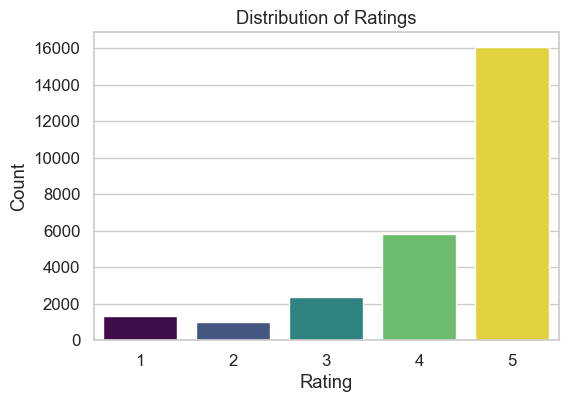

In [263]:
# 1. Distribution of Ratings
plt.figure(figsize=(6,4))
sns.countplot(
    x="rating", 
    hue="rating",       
    data=df, 
    palette="viridis", 
    legend=False        
)

plt.title("Distribution of Ratings")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

The majority of reviews are highly positive, with 5-star reviews dominating the dataset. This indicates a strong class imbalance where most users leave positive feedback, which may bias models towards predicting “not spam” or “positive.” Lower ratings (1–2 stars) are relatively rare, so special care may be needed during modeling (e.g., class weighting).

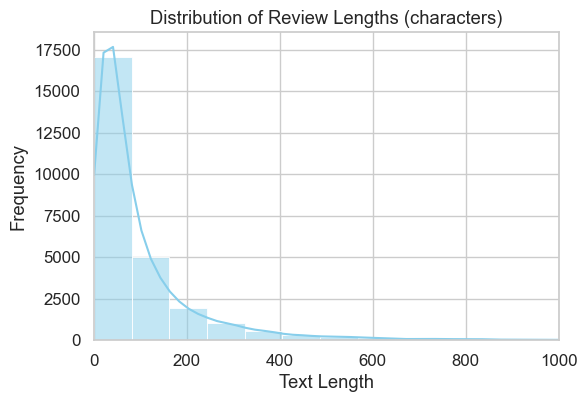

In [264]:
# 2. Review Length Distribution
plt.figure(figsize=(6,4))
sns.histplot(df["text_len"], bins=50, kde=True, color="skyblue")
plt.title("Distribution of Review Lengths (characters)")
plt.xlabel("Text Length")
plt.ylabel("Frequency")
plt.xlim(0, 1000)  # zoom in to filter extreme outliers
plt.show()

Most reviews are short (under 200 characters), with the distribution being heavily right-skewed. A few reviews are very long outliers (potentially spam or detailed experiences). This aligns with typical user behavior: many people leave brief comments, while a minority write detailed accounts.

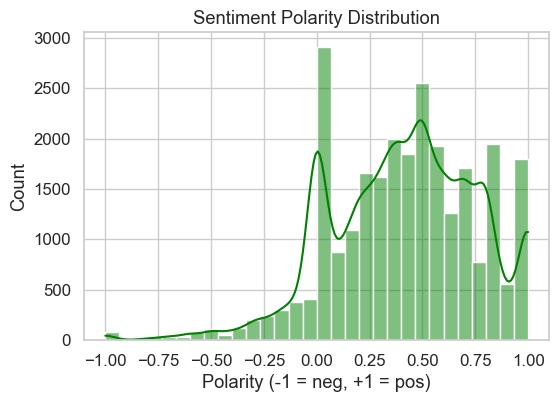

In [265]:
# 3. Sentiment Polarity Distribution
plt.figure(figsize=(6,4))
sns.histplot(df["sentiment_polarity"], bins=30, kde=True, color="green")
plt.title("Sentiment Polarity Distribution")
plt.xlabel("Polarity (-1 = neg, +1 = pos)")
plt.ylabel("Count")
plt.show()

The sentiment distribution is skewed towards the positive side, reflecting the rating distribution. Most reviews cluster around polarity values between 0.2 and 0.7, indicating moderately positive sentiment. However, there are also noticeable peaks near 0.0 (neutral reviews) and some highly negative reviews, though these are less frequent.

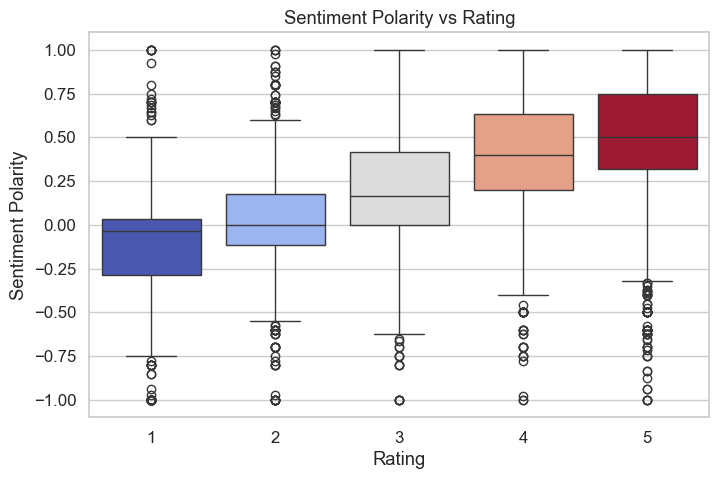

In [266]:
# 4. Sentiment vs Rating
plt.figure(figsize=(8,5))
sns.boxplot(
    x="rating", 
    y="sentiment_polarity", 
    hue="rating",       
    data=df, 
    palette="coolwarm", 
    legend=False        
)
plt.title("Sentiment Polarity vs Rating")
plt.xlabel("Rating")
plt.ylabel("Sentiment Polarity")
plt.show()

There is a clear positive relationship between ratings and sentiment polarity:

Low ratings (1–2) tend to have negative or neutral polarity.

High ratings (4–5) show more positive polarity.
However, there are some mismatches (e.g., 5-star reviews with negative sentiment or 1-star reviews with neutral/positive sentiment). These inconsistencies may point to spam, sarcasm, or low-quality reviews, and can serve as valuable features for detection.

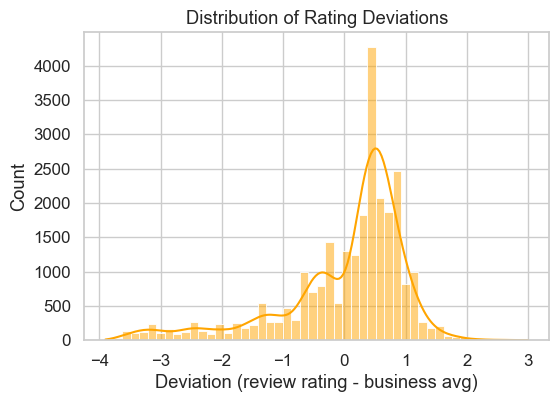

In [267]:
# 5. Rating Deviation Distribution
plt.figure(figsize=(6,4))
sns.histplot(df["rating_deviation"], bins=50, kde=True, color="orange")
plt.title("Distribution of Rating Deviations")
plt.xlabel("Deviation (review rating - business avg)")
plt.ylabel("Count")
plt.show()

Most reviews have ratings close to the business average (deviation near 0). However, there are noticeable outliers where user ratings deviate strongly (±2–3 stars) from the average. These extreme deviations may indicate biased, malicious, or irrelevant reviews, making this feature useful for spam/relevance classification.

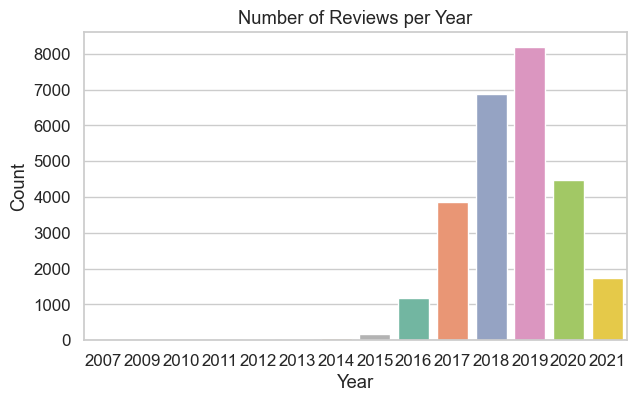

In [268]:
# 6. Reviews per Year
plt.figure(figsize=(7,4))
sns.countplot(
    x="year",
    hue="year",          
    data=df,
    palette="Set2",
    legend=False         
)
plt.title("Number of Reviews per Year")
plt.xlabel("Year")
plt.ylabel("Count")
plt.show()


The number of reviews grows steadily over time, peaking around 2018–2019. After that, there’s a decline into 2020–2021, which may be influenced by external factors such as COVID-19 reducing business activity and reviews. Temporal distribution also highlights potential periods of review “bursts,” which could correspond to coordinated spam campaigns.

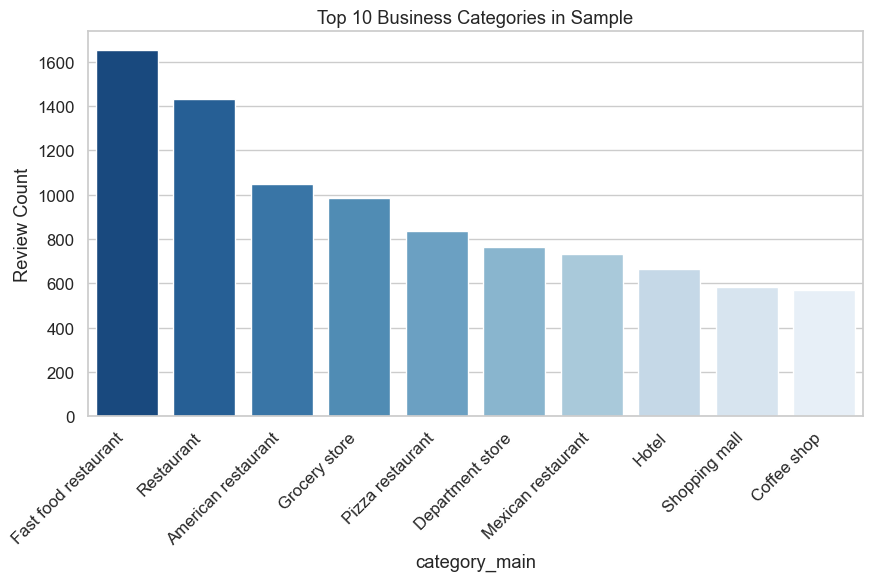

In [269]:
# 7. Category Distribution (Top categories)
plt.figure(figsize=(10,5))
cat_counts = df["category_main"].value_counts().nlargest(10)

sns.barplot(
    x=cat_counts.index,
    y=cat_counts.values,
    hue=cat_counts.index,      
    dodge=False,               
    palette="Blues_r",
    legend=False               
)

plt.title("Top 10 Business Categories in Sample")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Review Count")
plt.show()


The dataset is dominated by food-related businesses (e.g., fast food restaurants, American restaurants, pizza restaurants, grocery stores). This reflects the heavily skewed nature of online reviews toward the food and hospitality industry. Non-food categories (e.g., department stores, shopping malls, hotels) are also present but less frequent. This imbalance may affect generalizability across business types.